## Test Scikit-image Wiener implementation using Siemens star

This notebook was done to help trouble shoot for this [question](https://forum.image.sc/t/wiener-deconvolution-implementation-handling-complex-psf-in-scikit-image/94170).

The researcher noticed that the scikit image implementaiton of Wiener filter seemed to discard the phase component if the Fourier transform of the PSF was passed into the function.  So in this notebook we test Wiener both by passing in the spatial domain PSF and the frequency transformed PSF.

A Siemens star is a target used to test the resolution of a system see this [Wikipedia entry](https://en.wikipedia.org/wiki/Siemens_star).  

The test images can be found [here](http://bigwww.epfl.ch/deconvolution/data/siemens-star/)

## Define functions for PSF and forward model

This example has been designed to work in a conda environment that has numpy, matplotlib and skimage, and doesn't need complicated dependencies.  To make this example relatively independent of the experimental modules, In this block we define functions for

1.  A forward model -> Convolution + Poisson Noise
2.  A Gaussian PSF
4.  A 2d image plotting helper


In [1]:
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift
from numpy.random import poisson
import matplotlib.pyplot as plt

def forward(field, psf, max_photons, background_level, add_poisson=True):
    '''
        Note this function inspired by code from https://github.com/jdmanton/rl_positivity_sim by James Manton
    '''
    otf = fftn(fftshift(psf))
    field_imaged = ifftn(fftn(field)*otf)
    field_imaged = field_imaged/field_imaged.max()
    field_imaged = field_imaged*max_photons+background_level

    if add_poisson:
        return poisson(field_imaged.astype(float))
    else:
        return field_imaged.astype(float)

def gaussian_2d(xy_dim, xy_sigma, x_shift=0, y_shift=0):
    """ Generates a 2D Gaussian PSF
    
    Parameters:
    ----------
        xy_dim (int): the size of the PSF in the xy plane
        xy_sigma (float): the sigma of the Gaussian in the xy plane in pixels
    Returns:
    -------
        psf (numpy array): the PSF
    """
    muu = 0.0
    gauss = np.empty([xy_dim,xy_dim])

    x_, y_ = np.meshgrid(np.linspace(-(xy_dim//2),xy_dim//2,xy_dim), np.linspace(-(xy_dim//2),xy_dim//2,xy_dim))
    
    x_ = x_ - x_shift
    y_ = y_ - y_shift

    for x in range(xy_dim):
        for y in range(xy_dim):
            tx=x_[y,x]
            ty=y_[y,x]
            
            gauss[y,x]=np.exp(-( (tx-muu)**2 / ( 2.0 * xy_sigma**2 ) ) )*np.exp(-( (ty-muu)**2 / ( 2.0 * xy_sigma**2 ) ) )

    gauss=gauss/gauss.sum()

    return gauss


def imshow2d(im, width=8, height=6):
    fig, ax = plt.subplots(figsize=(width,height))
    ax.imshow(im)
    return fig


## Get and open test images

1.  Get images from this folder https://www.dropbox.com/sh/v3g5zln64e0uhk7/AABcYksPoawlTBO9ELCyqfPOa?dl=0
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder

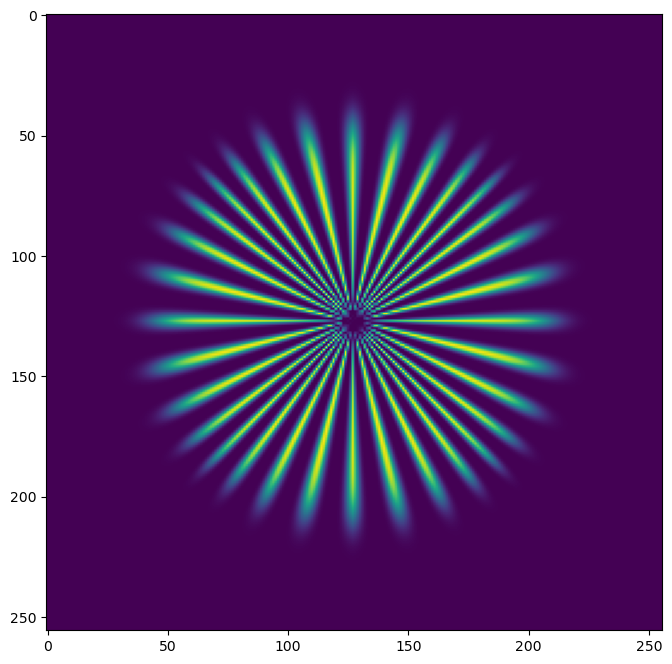

In [2]:
from skimage.io import imread

input_name = "D:\\images\\tnia-python-images\\deconvolution\\sinuosidal siemens star\\ref.tif"
#input_name = "D:\\images\\tnia-python-images\\deconvolution\\wheel\\wheel.tif"

truth=imread(input_name)

truth=truth.astype('float32')

fig=imshow2d(truth, 8, 8)

## Create the PSF

Now create the PSF.  Note we add a shift to the PSF.  This is because the error we are troubleshooting may only occur if the PSF has a phase (imaginary) component.

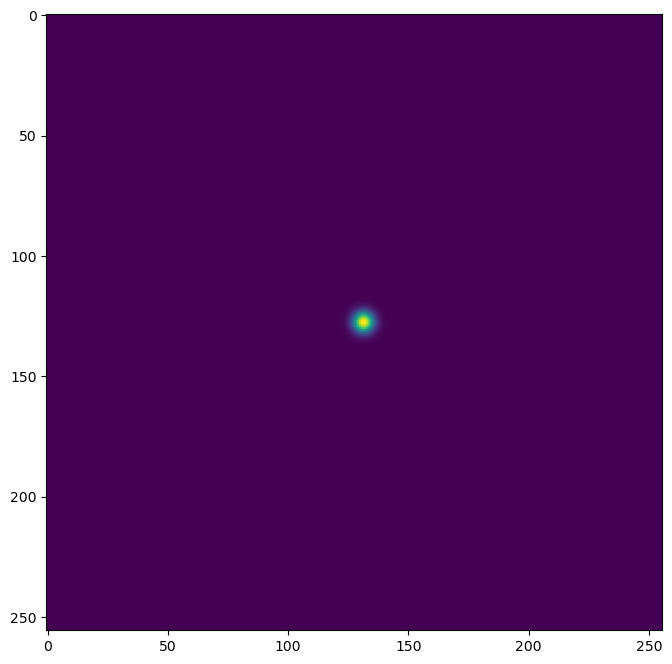

In [3]:

x_shift = 4

psf = gaussian_2d(truth.shape[0], 3, x_shift)

fig=imshow2d(psf,8,8)

## Apply the forward model

The forward model is convolution with a microscope PSF and the addition of Poisson noise.   Increasing max photons and/or decreasing background level will change the amount of noise in the image.  Change these parameters and rerun the downstream components and observe what happens.

C:\Users\bnort\AppData\Local\Temp\ipykernel_28708\296809018.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  return poisson(field_imaged.astype(float))


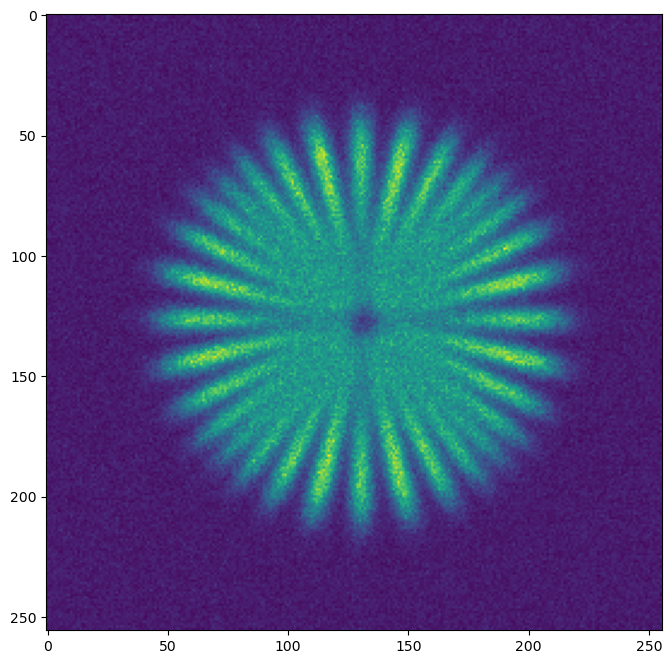

In [4]:
im = forward(truth, psf,max_photons=100,background_level=10, add_poisson=True).astype('float32')
fig = imshow2d(im,8,8)

# Perform Wiener Deconvolution 

We call Wiener 2 ways.

1.  Pass in spatial PSF
2.  Pass in frequency transformed PSF (OTF)

In [7]:
from skimage.restoration import uft
from skimage.restoration import wiener
test1 = wiener(im, psf, 0.1, clip=False)

otf = uft.ir2tf(psf, im.shape, is_real=True)
test2 = wiener(im, otf, 0.1, clip=False)


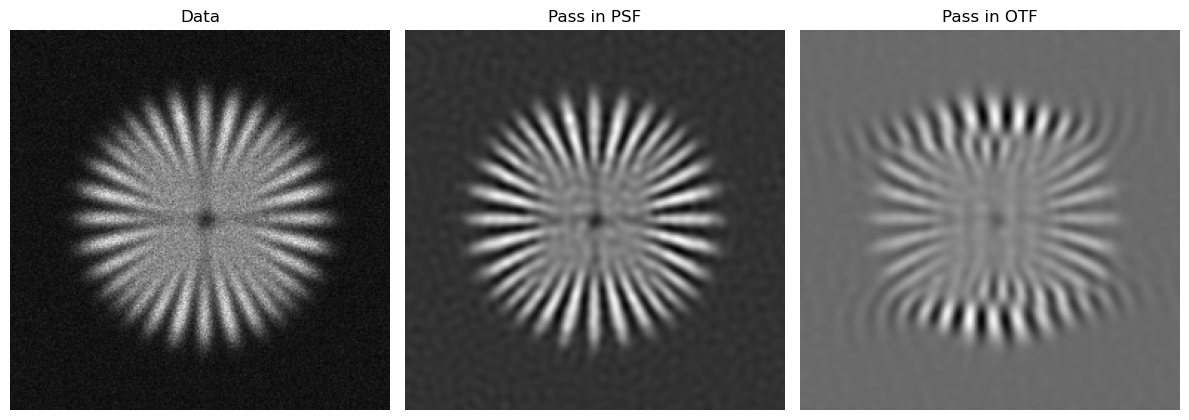

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5),
                       sharex=True, sharey=True)

plt.gray()

#ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].imshow(im)

ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(test1)
ax[1].axis('off')
ax[1].set_title('Pass in PSF')

ax[2].imshow(test2)
ax[2].axis('off')
ax[2].set_title('Pass in OTF')

fig.tight_layout()

plt.show()

In [18]:
import napari
viewer = napari.Viewer()
viewer.add_image(im)

viewer.layers[0].name

'im'